In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib, os, json
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading and inspecting CSVs

student_profile = pd.read_csv('student_profile.csv')
student_performance = pd.read_csv('student_performance.csv')
course_enrollment = pd.read_csv('course_enrollment.csv')
faculty_feedback = pd.read_csv('faculty_feedback.csv')
ai_insights = pd.read_csv('ai_insights.csv')

dfs = {
    "STUDENT_PROFILE": student_profile,
    "STUDENT_PERFORMANCE": student_performance,
    "COURSE_ENROLLMENT": course_enrollment,
    "FACULTY_FEEDBACK": faculty_feedback,
    "AI_INSIGHTS": ai_insights
}

for name, df in dfs.items():
    print(f"\n===== {name} =====")
    print(df.shape)
    print(df.head(2))
    print(df.info())
    print("-" * 60)


===== STUDENT_PROFILE =====
(14003, 5)
  Student_ID           Name             Program Year                     Email
0      S1000   Nathan Smith    Computer Science  3rd  costajessica@example.net
1      S1001  James Hickman  Business Analytics  3rd       april87@example.net
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14003 entries, 0 to 14002
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Student_ID  14003 non-null  object
 1   Name        14003 non-null  object
 2   Program     14003 non-null  object
 3   Year        14003 non-null  object
 4   Email       14003 non-null  object
dtypes: object(5)
memory usage: 547.1+ KB
None
------------------------------------------------------------

===== STUDENT_PERFORMANCE =====
(14003, 17)
  Student_ID  StudyHours  Attendance  Resources  Extracurricular  Motivation  \
0      S1000          19          64          1                0           0   
1      S1001          

In [3]:
# Standardize column names
def standardize_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

student_profile = standardize_columns(student_profile)
student_performance = standardize_columns(student_performance)
course_enrollment = standardize_columns(course_enrollment)
faculty_feedback = standardize_columns(faculty_feedback)
ai_insights = standardize_columns(ai_insights)

print("Student Profile Columns:", student_profile.columns.tolist())
print("AI Insights Columns:", ai_insights.columns.tolist())

# Merging Datasets
master = (
    student_profile
    .merge(student_performance, on="student_id", how="left")
    .merge(course_enrollment, on="student_id", how="left", suffixes=("", "_course"))
    .merge(faculty_feedback, on="student_id", how="left")
    .merge(ai_insights, on="student_id", how="left")
)

print(f"✅ Merged shape: {master.shape}")
display(master.head())

Student Profile Columns: ['student_id', 'name', 'program', 'year', 'email']
AI Insights Columns: ['insight_id', 'student_id', 'risk_level', 'message', 'date', 'semester']
✅ Merged shape: (26254, 34)


,student_id,name,program,year,email,studyhours,attendance,resources,extracurricular,motivation,...,grade,credits,feedback_id,date_x,feedback_text,insight_id,risk_level,message,date_y,semester
0,S1000,Nathan Smith,Computer Science,3rd,costajessica@example.net,19,64,1,0,0,...,86.0,3.0,F652,7/31/2024,Needs improvement in participation.,I0,Medium,Attendance could be improved.,6/15/2024,Fall 2024
1,S1001,James Hickman,Business Analytics,3rd,april87@example.net,19,64,1,0,0,...,NaN,NaN,F3426,10/25/2024,Good progress this semester.,I1,Low,Consider reaching out to your academic coach.,9/15/2024,Fall 2024
2,S1002,Thomas Waters,Data Science,4th,cassandraperez@example.com,19,64,1,0,0,...,56.0,4.0,F4484,1/12/2024,Excellent teamwork and attitude.,I2,Medium,Keep up the great work!,3/22/2024,Spring 2024
3,S1002,Thomas Waters,Data Science,4th,cassandraperez@example.com,19,64,1,0,0,...,51.0,3.0,F4484,1/12/2024,Excellent teamwork and attitude.,I2,Medium,Keep up the great work!,3/22/2024,Spring 2024
4,S1003,Adrian Ponce,Data Science,4th,thernandez@example.com,19,64,1,1,0,...,NaN,NaN,F11036,4/19/2024,Needs improvement in participation.,I3,Low,Consider reaching out to your academic coach.,7/7/2025,Spring 2025


In [4]:
# Data Cleaning and Preprocessing

# Checking for renamed columns after merge
print("Columns before renaming:", master.columns.tolist())

# Fixing Student_ID column name if changed
if "Student_ID_x" in master.columns:
    master.rename(columns={"Student_ID_x": "Student_ID"}, inplace=True)
if "Student_ID_y" in master.columns:
    master.drop(columns=["Student_ID_y"], inplace=True, errors="ignore")

# Removing duplicates safely
if "Student_ID" in master.columns:
    master.drop_duplicates(subset="Student_ID", keep="first", inplace=True)
else:
    print("⚠️ Warning: 'Student_ID' column not found after merge!")

# Handling missing values
fill_values = {}
if "Attendance" in master.columns:
    fill_values["Attendance"] = master["Attendance"].mean()
if "Grade" in master.columns:
    fill_values["Grade"] = master["Grade"].mean()
if "Motivation" in master.columns:
    fill_values["Motivation"] = master["Motivation"].median()
if "Feedback_Text" in master.columns:
    fill_values["Feedback_Text"] = "No feedback"

master.fillna(fill_values, inplace=True)

# Encoding categorical variables safely
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

if "Program" in master.columns:
    master["Program_enc"] = le.fit_transform(master["Program"].astype(str))

if "Risk_Level" in master.columns:
    master["Risk_Level_enc"] = le.fit_transform(master["Risk_Level"].astype(str))

if "Gender" in master.columns:
    master["Gender"] = master["Gender"].astype(int)

if "Internet" in master.columns:
    master["Internet"] = master["Internet"].astype(int)

print("✅ Data cleaning and encoding completed successfully.")
print("Final columns:", master.columns.tolist())

Columns before renaming: ['student_id', 'name', 'program', 'year', 'email', 'studyhours', 'attendance', 'resources', 'extracurricular', 'motivation', 'internet', 'gender', 'age', 'learningstyle', 'onlinecourses', 'discussions', 'assignmentcompletion', 'examscore', 'edutech', 'stresslevel', 'finalgrade', 'enrollment_id', 'course_name', 'attendance_course', 'grade', 'credits', 'feedback_id', 'date_x', 'feedback_text', 'insight_id', 'risk_level', 'message', 'date_y', 'semester']
⚠️ Warning: 'Student_ID' column not found after merge!
✅ Data cleaning and encoding completed successfully.
Final columns: ['student_id', 'name', 'program', 'year', 'email', 'studyhours', 'attendance', 'resources', 'extracurricular', 'motivation', 'internet', 'gender', 'age', 'learningstyle', 'onlinecourses', 'discussions', 'assignmentcompletion', 'examscore', 'edutech', 'stresslevel', 'finalgrade', 'enrollment_id', 'course_name', 'attendance_course', 'grade', 'credits', 'feedback_id', 'date_x', 'feedback_text', '

In [5]:
# Feature Engineering

# Normalize column names
master.columns = master.columns.str.lower()

print("\n✅ Normalized column names:\n", master.columns.tolist())

# Handling duplicates and ensure necessary columns exist

def get_col(colname):
    """Helper to safely return column even if similar name exists."""
    for c in master.columns:
        if c.lower() == colname.lower():
            return c
    matches = [c for c in master.columns if colname.lower() in c.lower()]
    return matches[0] if matches else None

# Safely pick correct column names
study_col = get_col("studyhours")
attend_col = get_col("attendance")
motiv_col = get_col("motivation")
grade_col = get_col("grade")
stress_col = get_col("stresslevel")

print(f"\nResolved columns:\nStudyHours → {study_col}\nAttendance → {attend_col}\nMotivation → {motiv_col}\nGrade → {grade_col}\nStressLevel → {stress_col}")

# Calculating Engagement_Score
master["engagement_score"] = (
    master[study_col].astype(float) * 0.4 +
    master[attend_col].astype(float) * 0.3 +
    master[motiv_col].astype(float) * 0.3
)

# Normalizing numeric features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

num_cols = [study_col, attend_col, motiv_col, grade_col, "engagement_score", stress_col]
existing_cols = [col for col in num_cols if col in master.columns]
master[existing_cols] = scaler.fit_transform(master[existing_cols])

# Encoding Risk Level
from sklearn.preprocessing import LabelEncoder
if "risk_level_enc" not in master.columns:
    le = LabelEncoder()
    master["risk_level_enc"] = le.fit_transform(master["risk_level"].astype(str))

# Droping irrelevant text fields safely
drop_cols = ["student_id", "name", "email", "feedback_text", "risk_level", "insight_id"]
X = master.drop(columns=[c for c in drop_cols if c in master.columns], errors="ignore")

# Define features and label
y = master["risk_level_enc"]

print("\n✅ Features and target variable ready.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


✅ Normalized column names:
 ['student_id', 'name', 'program', 'year', 'email', 'studyhours', 'attendance', 'resources', 'extracurricular', 'motivation', 'internet', 'gender', 'age', 'learningstyle', 'onlinecourses', 'discussions', 'assignmentcompletion', 'examscore', 'edutech', 'stresslevel', 'finalgrade', 'enrollment_id', 'course_name', 'attendance_course', 'grade', 'credits', 'feedback_id', 'date_x', 'feedback_text', 'insight_id', 'risk_level', 'message', 'date_y', 'semester']

Resolved columns:
StudyHours → studyhours
Attendance → attendance
Motivation → motivation
Grade → grade
StressLevel → stresslevel

✅ Features and target variable ready.
Shape of X: (26254, 30)
Shape of y: (26254,)


In [6]:
# Define Features and Target

# Find target column automatically
target_col = None
for c in master.columns:
    if "risk" in c.lower():
        target_col = c
        break

if target_col is None:
    raise KeyError("❌ Risk level column not found.")
else:
    print(f"✅ Target column detected: {target_col}")

# Define X and y
X = master.drop(columns=[target_col], errors="ignore")
y = master[target_col].astype(str)

# Remove any purely text or ID columns from X
X = X.select_dtypes(include=["int64", "float64"])  # keeps only numeric columns

# Encode y
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

# --- 7. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- 8. Train Model ---
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print(f"✅ Best Params: {grid.best_params_}")

✅ Target column detected: risk_level
Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [7]:
# --- 8. Evaluate Model ---
y_pred = best_model.predict(X_test)

print("\n=== Model Performance Summary ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


=== Model Performance Summary ===
Accuracy: 1.000

Confusion Matrix:
 [[1282    0    0]
 [   0 3346    0]
 [   0    0 1936]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1282
           1       1.00      1.00      1.00      3346
           2       1.00      1.00      1.00      1936

    accuracy                           1.00      6564
   macro avg       1.00      1.00      1.00      6564
weighted avg       1.00      1.00      1.00      6564



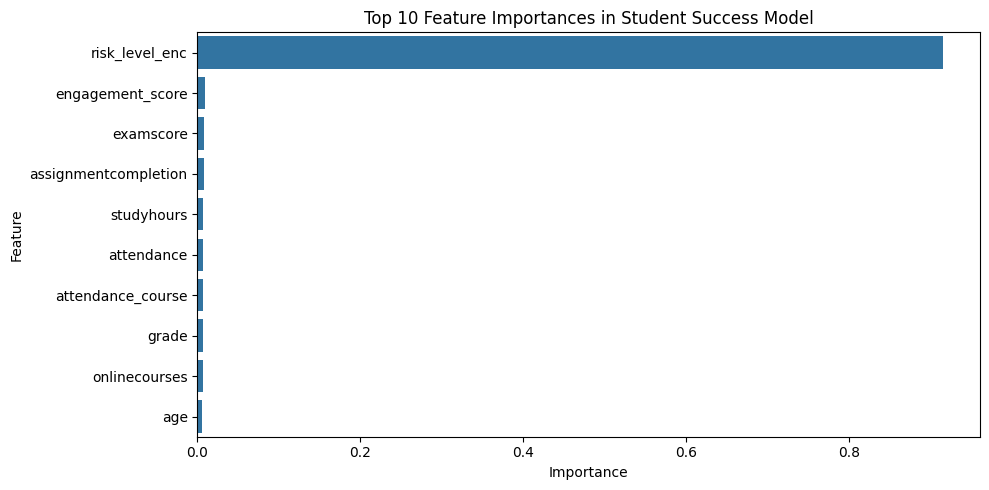

,Feature,Importance
20,risk_level_enc,0.915413
19,engagement_score,0.008962
12,examscore,0.008052
11,assignmentcompletion,0.007963
0,studyhours,0.007303
1,attendance,0.007057
16,attendance_course,0.006852
17,grade,0.006833
9,onlinecourses,0.006266
7,age,0.005372


In [8]:
# --- Feature Importance Visualization (Fixed Version) ---

# Get the actual feature names used by the model
feature_names = X_train.columns

# Extract feature importances from the trained model
importances = best_model.feature_importances_

# Create a DataFrame using the correct names and lengths
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(10))
plt.title("Top 10 Feature Importances in Student Success Model")
plt.tight_layout()
plt.show()

feat_importance.head(15)

In [11]:
print(X_train.columns.tolist())

['studyhours', 'attendance', 'resources', 'extracurricular', 'motivation', 'internet', 'gender', 'age', 'learningstyle', 'onlinecourses', 'discussions', 'assignmentcompletion', 'examscore', 'edutech', 'stresslevel', 'finalgrade', 'attendance_course', 'grade', 'credits', 'engagement_score', 'risk_level_enc']
